In [1]:
import yfinance as yf
import requests
import os
#yfinance is a widely used Python library that provides a convenient and efficient way to access and download financial data from Yahoo Finance.
import pandas as pd
import pandas_ta as ta
#Pandas Technical Analysis (pandas_ta) is a Python library designed for technical analysis of financial data. It extends the popular Pandas library, providing a wide array of technical indicators and utility functions directly accessible from Pandas DataFrames.
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import warnings
import random
import holidays
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv('./vars.env')
api_key=os.getenv("polygon_key")

In [29]:
# Define parameters
SYMBOL = 'QQQ'
RSI_PERIOD = 14
OVERBOUGHT = 70
OVERSOLD = 30
REVERSAL_THRESHOLD = 0.005  # 0.5% price move to confirm reversal
REVERSAL_WINDOW = 2  # Number of 5-minute bars to check for reversal, 10 mins after signal apears
LOOKAHEAD_MINUTES = [5, 10, 15]  # Minutes to measure price change, let's look at relatively in short time frame
START_DATE = (datetime.today() - timedelta(days=90)).strftime('%Y-%m-%d')  # Reduced to 60 days
END_DATE = datetime.today().strftime('%Y-%m-%d')
CACHE_FILE = 'qqq_intraday_data.csv'
POLYGON_API_KEY = api_key

In [8]:
# Function to check if a date is a trading day
def is_trading_day(date):
    # Exclude weekends (Saturday=5, Sunday=6)
    if date.weekday() >= 5:
        return False
    # Check for U.S. market holidays
    us_holidays = holidays.US(years=date.year)
    # Common NYSE holidays (approximate for 2025)
    market_holidays = [
        f"{date.year}-01-01",  # New Year's Day
        f"{date.year}-01-20",  # Martin Luther King Jr. Day
        f"{date.year}-02-17",  # Presidents' Day
        f"{date.year}-04-18",  # Good Friday
        f"{date.year}-05-26",  # Memorial Day
        f"{date.year}-06-19",  # Juneteenth
        f"{date.year}-07-04",  # Independence Day
        f"{date.year}-09-01",  # Labor Day
        f"{date.year}-11-27",  # Thanksgiving
        f"{date.year}-12-25",  # Christmas
    ]
    return date.strftime('%Y-%m-%d') not in market_holidays and date not in us_holidays

# Function to fetch intraday data with Polygon.io, skipping non-trading days
def fetch_intraday_data(symbol, start_date, end_date, interval='5min', chunk_days=30, max_retries=3, cache_file=CACHE_FILE):
    # Validate API key
    if POLYGON_API_KEY == 'YOUR_POLYGON_API_KEY':
        raise ValueError("Polygon.io API key not set. Please replace 'YOUR_POLYGON_API_KEY' with your actual API key.")

    # Check if cached data exists and is valid
    if os.path.exists(cache_file):
        print(f"Loading data from {cache_file}...")
        try:
            data = pd.read_csv(cache_file, index_col='Date', parse_dates=True)
            data_start = data.index.min()
            data_end = data.index.max()
            req_start = datetime.strptime(start_date, '%Y-%m-%d')
            req_end = datetime.strptime(end_date, '%Y-%m-%d')
            if data_start <= req_start and data_end >= req_end:
                print("Cached data is valid.")
                return data[(data.index >= req_start) & (data.index <= req_end)]
            else:
                print("Cached data is outdated or incomplete. Fetching new data...")
        except Exception as e:
            print(f"Error loading cache: {e}. Fetching new data...")

    try:
        base_url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/5/minute"
        start = datetime.strptime(start_date, '%Y-%m-%d')
        end = datetime.strptime(end_date, '%Y-%m-%d')
        data_frames = []

        # Generate list of trading days
        trading_days = []
        current_date = start
        while current_date <= end:
            if is_trading_day(current_date):
                trading_days.append(current_date)
            current_date += timedelta(days=1)

        if not trading_days:
            print("No trading days in the specified date range. Falling back to daily data.")
            return fetch_daily_data(symbol, start_date, end_date, cache_file)

        # Break trading days into chunks
        chunk_start_idx = 0
        while chunk_start_idx < len(trading_days):
            chunk_end_idx = min(chunk_start_idx + chunk_days, len(trading_days))
            chunk_start_date = trading_days[chunk_start_idx]
            chunk_end_date = trading_days[chunk_end_idx - 1]
            retries = 0
            while retries < max_retries:
                try:
                    print(f"Fetching data from {chunk_start_date.strftime('%Y-%m-%d')} to {chunk_end_date.strftime('%Y-%m-%d')}...")
                    url = f"{base_url}/{chunk_start_date.strftime('%Y-%m-%d')}/{chunk_end_date.strftime('%Y-%m-%d')}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"
                    response = requests.get(url)
                    if response.status_code == 429:
                        print(f"Rate limit hit (429). Retrying ({retries + 1}/{max_retries}) after 20 seconds...")
                        time.sleep(20)
                        retries += 1
                        continue
                    response.raise_for_status()
                    data_json = response.json()
                    print(f"API response: status={data_json.get('status')}, results_count={data_json.get('resultsCount', 0)}")
                    if data_json.get('status') != 'OK' or 'results' not in data_json or not data_json['results']:
                        print("No data returned or invalid response.")
                        break
                    bars = data_json['results']
                    df = pd.DataFrame(bars)
                    df['Date'] = pd.to_datetime(df['t'], unit='ms')
                    df.set_index('Date', inplace=True)
                    df = df[['o', 'h', 'l', 'c', 'v']]
                    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
                    data_frames.append(df)
                    break
                except Exception as e:
                    print(f"Error fetching data: {e}")
                    retries += 1
                    time.sleep(20)
            if retries == max_retries:
                print(f"Max retries reached for {chunk_start_date} to {chunk_end_date}. Skipping chunk.")
            chunk_start_idx = chunk_end_idx
            time.sleep(15)  # Respect Polygon.io free tier rate limit (5 calls/min)

        if data_frames:
            data = pd.concat(data_frames)
            data = data[~data.index.duplicated(keep='first')]  # Remove duplicates
            try:
                data.to_csv(cache_file)
                print(f"Data saved to {cache_file}")
            except Exception as e:
                print(f"Error saving cache: {e}")
            return data
        else:
            print("No intraday data available. Falling back to daily data.")
            return fetch_daily_data(symbol, start_date, end_date, cache_file)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

# Helper function to fetch daily data (fallback)
def fetch_daily_data(symbol, start_date, end_date, cache_file):
    try:
        url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={POLYGON_API_KEY}"
        response = requests.get(url)
        response.raise_for_status()
        data_json = response.json()
        if data_json.get('status') == 'OK' and 'results' in data_json and data_json['results']:
            bars = data_json['results']
            df = pd.DataFrame(bars)
            df['Date'] = pd.to_datetime(df['t'], unit='ms')
            df.set_index('Date', inplace=True)
            df = df[['o', 'h', 'l', 'c', 'v']]
            df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            try:
                df.to_csv(cache_file)
                print(f"Daily data saved to {cache_file}")
            except Exception as e:
                print(f"Error saving cache: {e}")
            return df
        return pd.DataFrame()
    except Exception as e:
        print(f"Error fetching daily data: {e}")
        return pd.DataFrame()

In [9]:
df = fetch_intraday_data(SYMBOL, START_DATE, END_DATE)

Loading data from qqq_intraday_data.csv...
Cached data is outdated or incomplete. Fetching new data...
Fetching data from 2025-03-24 to 2025-05-05...
API response: status=OK, results_count=5746
Fetching data from 2025-05-06 to 2025-06-17...
API response: status=OK, results_count=5739
Fetching data from 2025-06-18 to 2025-06-20...
API response: status=OK, results_count=384
Data saved to qqq_intraday_data.csv


In [6]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-06-20 23:35:00,527.3900,527.5000,527.39,527.5000,3032.0
2025-06-20 23:40:00,527.5763,527.5763,527.45,527.4800,5163.0
2025-06-20 23:45:00,527.4517,527.5500,527.41,527.4100,3657.0
2025-06-20 23:50:00,527.4100,527.5901,527.41,527.5901,8452.0
2025-06-20 23:55:00,527.5900,527.5900,527.40,527.5599,8411.0


In [27]:
# Function to fetch intraday data using yfinance
# def fetch_intraday_data_safe(symbol, start_date, end_date, interval='5m', max_retries=5):
#     retries = 0
#     while retries < max_retries:
#         try:
#             df = yf.download(symbol, start=start_date, end=end_date, interval=interval, progress=False)
#             if not df.empty:
#                 return df
#             else:
#                 print("No data. Trying daily.")
#                 df = yf.download(symbol, start=start_date, end=end_date, interval='1d', progress=False)
#                 return df
#         except Exception as e:
#             print(f"Error: {e}. Retrying in 60 seconds...")
#             time.sleep(120)
#             retries += 1
#     print("Failed to fetch data after multiple attempts.")
#     return pd.DataFrame()
#
# # Usage
# df = fetch_intraday_data_safe(SYMBOL, START_DATE, END_DATE, interval='5m')
# print(df.head())


1 Failed download:
['QQQ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


No data. Trying daily.



1 Failed download:
['QQQ']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Empty DataFrame
Columns: [(Adj Close, QQQ), (Close, QQQ), (High, QQQ), (Low, QQQ), (Open, QQQ), (Volume, QQQ)]
Index: []


In [ ]:
df = fetch_intraday_data(SYN, start_date, end_date, interval='5m')

In [14]:
# finnhub free account does not offer access to ticker QQQ
# def fetch_intraday_data(symbol, start_date, end_date, interval='5m', token=api_key):
#     """
#     Download historical stock price data using Finnhub API.
#     interval: '1m', '5m', '15m', '30m', '60m', 'D', etc.
#     """
#     # Finnhub intervals are '1', '5', '15', '30', '60' for intraday (in minutes)
#     interval_map = {'1m': '1', '5m': '5', '15m': '15', '30m': '30', '60m': '60', 'D': 'D'}
#     finnhub_interval = interval_map.get(interval, '5')
#
#     start_dt = datetime.strptime(start_date, '%Y-%m-%d')
#     end_dt = datetime.strptime(end_date, '%Y-%m-%d')
#     all_data = []
#     cur_start = start_dt
#
#     while cur_start < end_dt:
#         cur_end = min(cur_start + timedelta(days=30), end_dt)
#         from_ts = int(cur_start.timestamp())
#         to_ts = int(cur_end.timestamp())
#
#         url = 'https://finnhub.io/api/v1/stock/candle'
#         params = {
#             'symbol': symbol,
#             'resolution': finnhub_interval,
#             'from': from_ts,
#             'to': to_ts,
#             'token': token
#         }
#         for attempt in range(3):
#             try:
#                 r = requests.get(url, params=params)
#                 r.raise_for_status()
#                 result = r.json()
#                 if result.get('s') != 'ok':
#                     print(f"No intraday data for {symbol} from {cur_start} to {cur_end}")
#                     break
#                 df = pd.DataFrame({
#                     'time': pd.to_datetime(result['t'], unit='s'),
#                     'Open': result['o'],
#                     'High': result['h'],
#                     'Low': result['l'],
#                     'Close': result['c'],
#                     'Volume': result['v'],
#                 }).set_index('time')
#                 all_data.append(df)
#                 break
#             except Exception as e:
#                 print(f"Error fetching {symbol}: {e}")
#                 if attempt < 2:
#                     wait = 2 ** attempt + random.uniform(0, 2)
#                     print(f"Retrying after {wait:.2f} seconds...")
#                     time.sleep(wait)
#                 else:
#                     print(f"Max retries exceeded for {symbol} chunk {cur_start} to {cur_end}. Skipping.")
#         cur_start = cur_end + timedelta(days=1)
#         # avoid hammering the server
#         time.sleep(random.uniform(1, 2))
#
#     if all_data:
#         data = pd.concat(all_data)
#         data = data[~data.index.duplicated(keep='first')]
#         return data
#     else:
#         print("No intraday data available. Falling back to daily data.")
#         # Try daily candles
#         try:
#             from_ts = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
#             to_ts = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
#             params_daily = {
#                 'symbol': symbol,
#                 'resolution': 'D',
#                 'from': from_ts,
#                 'to': to_ts,
#                 'token': token
#             }
#             r = requests.get(url, params=params_daily)
#             r.raise_for_status()
#             result = r.json()
#             if result.get('s') == 'ok':
#                 df = pd.DataFrame({
#                     'time': pd.to_datetime(result['t'], unit='s'),
#                     'Open': result['o'],
#                     'High': result['h'],
#                     'Low': result['l'],
#                     'Close': result['c'],
#                     'Volume': result['v'],
#                 }).set_index('time')
#                 return df
#             else:
#                 print("No daily data found either.")
#                 return pd.DataFrame()
#         except Exception as e:
#             print(f"Error fetching daily data: {e}")
#             return pd.DataFrame()

In [21]:
# def fetch_intraday_data(symbol, start_date, end_date, interval='5min', api_key='YOUR_ALPHA_VANTAGE_KEY'):
#     """
#     Download intraday stock data using Alpha Vantage API.
#
#     Parameters:
#         symbol: str, stock ticker
#         start_date: str, 'YYYY-MM-DD'
#         end_date: str, 'YYYY-MM-DD'
#         interval: str, '1min', '5min', '15min', '30min', or '60min'
#         api_key: str, your Alpha Vantage API key
#
#     Returns:
#         pd.DataFrame with datetime index and OHLCV columns
#     """
#     # Alpha Vantage only allows outputsize='full' for the entire available period (~1 month for 5min)
#     url = "https://www.alphavantage.co/query"
#     params = {
#         "function": "TIME_SERIES_INTRADAY",
#         "symbol": symbol,
#         "interval": interval,
#         "apikey": api_key,
#         "outputsize": "full"   # gets as much data as possible in one call
#     }
#
#     try:
#         response = requests.get(url, params=params)
#         response.raise_for_status()
#         data = response.json()
#         key = f"Time Series ({interval})"
#         if key not in data:
#             print(f"No intraday data found for {symbol}. Response: {data}")
#             return pd.DataFrame()
#         df = pd.DataFrame.from_dict(data[key], orient="index")
#         df.index = pd.to_datetime(df.index)
#         df = df.sort_index()
#         df = df.rename(columns=lambda x: x.split('. ')[1].capitalize())
#         # Filter by date range
#         mask = (df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date) + timedelta(days=1))
#         df = df.loc[mask]
#         return df
#     except Exception as e:
#         print(f"Error fetching data: {e}")
#         return pd.DataFrame()

In [22]:
df = fetch_intraday_data(SYMBOL, START_DATE, END_DATE, interval='5m')

No intraday data found for QQQ. Response: {'Error Message': 'Invalid API call. Please retry or visit the documentation (https://www.alphavantage.co/documentation/) for TIME_SERIES_INTRADAY.'}


In [10]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-24 08:00:00,485.66,486.09,484.72,486.09,28781.0
2025-03-24 08:05:00,486.20,486.71,486.17,486.68,10791.0
2025-03-24 08:10:00,486.70,486.89,486.53,486.89,11360.0
2025-03-24 08:15:00,486.91,486.99,486.44,486.45,12497.0
2025-03-24 08:20:00,486.49,486.64,486.26,486.62,6590.0


In [12]:
#the df.index return the time stamp
df.index

DatetimeIndex(['2025-03-24 08:00:00', '2025-03-24 08:05:00',
               '2025-03-24 08:10:00', '2025-03-24 08:15:00',
               '2025-03-24 08:20:00', '2025-03-24 08:25:00',
               '2025-03-24 08:30:00', '2025-03-24 08:35:00',
               '2025-03-24 08:40:00', '2025-03-24 08:45:00',
               ...
               '2025-06-20 23:10:00', '2025-06-20 23:15:00',
               '2025-06-20 23:20:00', '2025-06-20 23:25:00',
               '2025-06-20 23:30:00', '2025-06-20 23:35:00',
               '2025-06-20 23:40:00', '2025-06-20 23:45:00',
               '2025-06-20 23:50:00', '2025-06-20 23:55:00'],
              dtype='datetime64[ns]', name='Date', length=11869, freq=None)

In [16]:
df.index.get_loc('2025-06-20 23:25:00')
#df.index.get_loc() take real index as input, which is time stamp in this case
#it returns the integer position of that row in the dataframe

11862

In [19]:
# Function to calculate RSI and identify signals
def calculate_rsi_signals(data):
    # Calculate RSI using pandas_ta
    data['RSI'] = ta.rsi(data['Close'], length=RSI_PERIOD)
    # Identify overbought and oversold signals
    data['Overbought'] = data['RSI'] > OVERBOUGHT
    data['Oversold'] = data['RSI'] < OVERSOLD
    # Mark signal points (first occurrence after crossing threshold)
    data['Signal'] = None

    #detect the momentum when the signal occurs (this does not consider if the RSI remains 'Overbought'/'Oversold' for several consecutive time windows
    for i in range(1, len(data)):
        if data['Overbought'].iloc[i] and not data['Overbought'].iloc[i-1]:
            data.loc[data.index[i], 'Signal'] = 'Sell'
        elif data['Oversold'].iloc[i] and not data['Oversold'].iloc[i-1]:
            data.loc[data.index[i], 'Signal'] = 'Buy'
    return data

# Function to detect reversals
def detect_reversals(data):
    data['Reversal'] = False
    for idx, row in data[data['Signal'].notnull()].iterrows(): #loop through all rows there is a signal
        signal_type = row['Signal']
        signal_price = row['Close'] #the close price when signal event occurs, used as benchmark
        # Get next REVERSAL_WINDOW bars

        #starting from signal 5-min bars, we will look at 5 bars (25 mins for 5 min data) after the signal row
        end_idx = data.index.get_loc(idx) + REVERSAL_WINDOW

        #if the reversal window expand beyond the end of dataframe, skip the rest of the current iteration, no window_data will be created
        if end_idx >= len(data):
            continue

        #window_data includes the n bars (5 min) of time window after the signal appears, here it is 3-5 bars
        window_data = data.iloc[data.index.get_loc(idx)+1:end_idx+1]
        if signal_type == 'Sell':
            # Bearish reversal: price drops by threshold
            if window_data['Close'].min() <= signal_price * (1 - REVERSAL_THRESHOLD):
                data.loc[idx, 'Reversal'] = True
        elif signal_type == 'Buy':
            # Bullish reversal: price rises by threshold
            if window_data['Close'].max() >= signal_price * (1 + REVERSAL_THRESHOLD):
                data.loc[idx, 'Reversal'] = True
    return data

# Function to calculate price changes after signals

# Function to calculate price changes after signals
def calculate_price_changes(data, lookahead_minutes):
    results = []
    for idx, row in data[data['Signal'].notnull()].iterrows():
        signal_date = idx
        signal_price = row['Close']
        signal_type = row['Signal']
        reversal = row['Reversal']
        for minutes in lookahead_minutes:
            #look at the n bars/mins afte signal appears, the price change
            bars_ahead = int(np.ceil(minutes / 5))
            target_idx = data.index.get_loc(idx) + bars_ahead
            if target_idx >= len(data):
                continue
            future_price = data.iloc[target_idx]['Close']
            price_change = (future_price - signal_price) / signal_price * 100
            results.append({
                'Signal_Date': signal_date,
                'Signal_Type': signal_type,
                'Reversal': reversal,
                'Minutes_Ahead': minutes,
                'Price_Change (%)': price_change
            })
    return pd.DataFrame(results)

Calculating RSI and signals...
Detecting reversals...
Calculating price changes...

Analysis Results:

Reversal Probability (%):
Signal
Buy     2.525253
Sell    2.673797
Name: Reversal, dtype: float64

Average Price Change (%) After Signals:
                               mean       std  count
Signal_Type Minutes_Ahead                           
Buy         5              0.025940  0.345335    198
            10             0.028586  0.413221    198
            15             0.048543  0.478088    198
Sell        5              0.006785  0.212099    187
            10            -0.010957  0.314566    187
            15             0.011866  0.500336    187


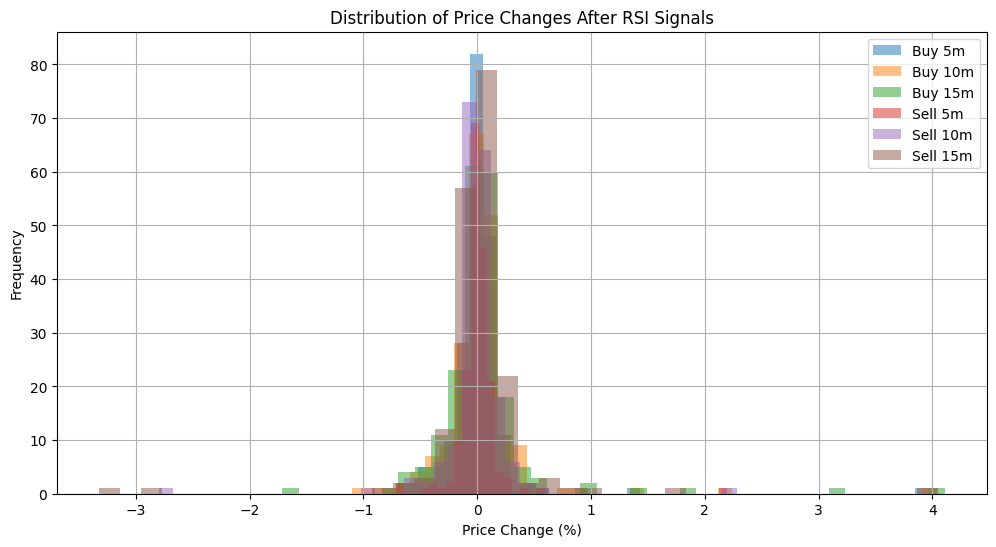

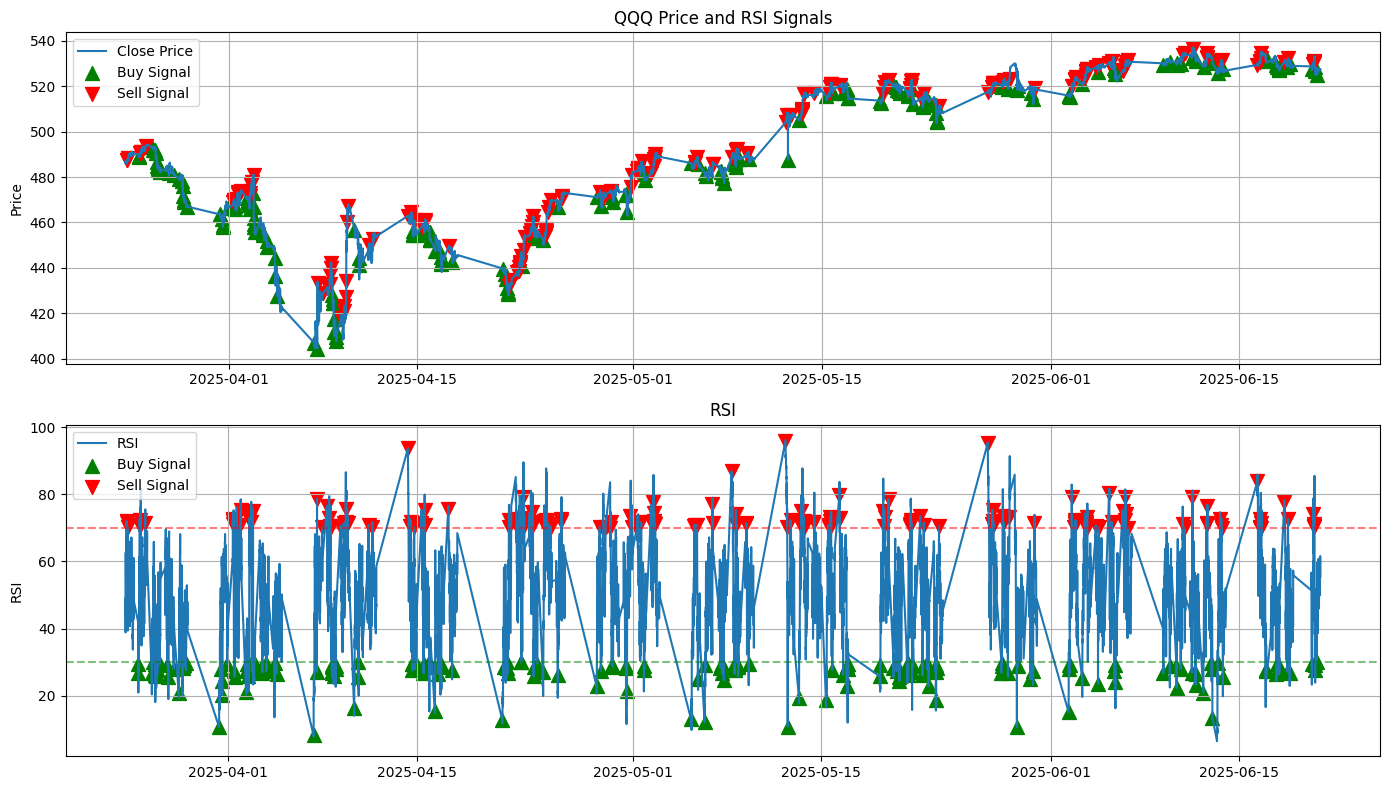

In [31]:
# Main analysis function
def analyze_rsi_reversals(data):
    # print("Fetching data...")
    # data = fetch_intraday_data(SYMBOL, START_DATE, END_DATE)
    # if data.empty:
    #     print("No data available. Exiting.")
    #     return

    print("Calculating RSI and signals...")
    data = calculate_rsi_signals(data)

    print("Detecting reversals...")
    data = detect_reversals(data)

    print("Calculating price changes...")
    price_changes = calculate_price_changes(data, LOOKAHEAD_MINUTES)

    print("\nAnalysis Results:")
    signals = data[data['Signal'].notnull()] #final all time moment that signal appears
    if not signals.empty:
        reversal_prob = signals.groupby('Signal')['Reversal'].mean() * 100
        signals.to_csv('signals.csv')
        print("\nReversal Probability (%):")
        print(reversal_prob)

    if not price_changes.empty:
        print("\nAverage Price Change (%) After Signals:")
        price_stats = price_changes.groupby(['Signal_Type', 'Minutes_Ahead'])['Price_Change (%)'].agg(['mean', 'std', 'count'])
        print(price_stats)

        plt.figure(figsize=(12, 6))
        for signal in ['Buy', 'Sell']:
            for minutes in LOOKAHEAD_MINUTES:
                subset = price_changes[(price_changes['Signal_Type'] == signal) & (price_changes['Minutes_Ahead'] == minutes)]
                plt.hist(subset['Price_Change (%)'], bins=40, alpha=0.5, label=f'{signal} {minutes}m')
        plt.title('Distribution of Price Changes After RSI Signals')
        plt.xlabel('Price Change (%)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Scatter plot: Price Change (%) vs. Price Change (%)
        # plt.figure(figsize=(12, 6))
        # markers = {'Buy': '^', 'Sell': 'o'}  # Triangle for Buy, Circle for Sell
        # colors = {10: 'blue', 20: 'green', 30: 'red'}  # Colors for time intervals
        # for signal in ['Buy', 'Sell']:
        #     for minutes in LOOKAHEAD_MINUTES:
        #         subset = price_changes[(price_changes['Signal_Type'] == signal) & (price_changes['Minutes_Ahead'] == minutes)]
        #         plt.scatter(
        #             subset['Price_Change (%)'],
        #             subset['Signal_Type'],
        #             marker=markers[signal],
        #             c=colors[minutes],
        #             alpha=0.6,
        #             s=100,
        #             label=f'{signal} {minutes}m'
        #         )
        # plt.title('Price Changes After RSI Signals (X=Y)')
        # plt.xlabel('Price Change (%)')
        # plt.ylabel('Price Change (%)')
        # plt.legend()
        # plt.grid(True)
        # plt.tight_layout()
        # plt.show()

    plt.figure(figsize=(14, 8))
    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price')
    buy_signals = data[data['Signal'] == 'Buy']
    sell_signals = data[data['Signal'] == 'Sell']
    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)
    plt.title(f'{SYMBOL} Price and RSI Signals')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['RSI'], label='RSI')
    plt.axhline(OVERBOUGHT, color='r', linestyle='--', alpha=0.5)
    plt.axhline(OVERSOLD, color='g', linestyle='--', alpha=0.5)
    plt.scatter(buy_signals.index, buy_signals['RSI'], marker='^', color='g', label='Buy Signal', s=100)
    plt.scatter(sell_signals.index, sell_signals['RSI'], marker='v', color='r', label='Sell Signal', s=100)
    plt.title('RSI')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    analyze_rsi_reversals(df)